In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [331]:
import glob
import warnings
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot
from utils.utils import midPoint, stride, rolling_std, radialMask
from zernikies import zernikeWLS, getZernikeCoeffs
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
from scipy.optimize import least_squares

def parabolaFit(x, y, z, guess, bounds=None, 
                max_nfev=10000, ftol=1e-12, 
                xtol=1e-12, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        b1 = [0., -inf, -inf, -inf, -pi2, -pi2]
        b2 = [inf, inf,  inf,  inf,  pi2,  pi2]
        bounds = (b1, b2)
    
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    f_scale = 1.0

    method = fitParabola
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method,
                      guess,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol)
    return r

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, bounds=bounds)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
    
    return fit, mask

def removeParabolaScan(filename, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None, fit=None):
    """
    """
    
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(178)])
    fit_, refMask = parabolaFitIterations(xg, yg, zg, guess=guess, bounds=bounds, iters=iters)
    if fit is None:
        fit = fit_
    cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(xg, yg, zg, cor)
    zgdr[refMask] = np.nan
    tht = np.arctan2(np.nanmax(zgdr)-np.nanmin(zgdr), np.nanmax(ygdr)-np.nanmin(ygdr))
    xgr, ygr, zgr = shiftRotateXYZ(xgdr, ygdr, zgdr, [0, 0, 0, -tht, 0, 0])
    zp = parabola(xgdr, ygdr, fit.x[0])
    _, _, zpr = shiftRotateXYZ(xgdr, ygdr, zp, [0, 0, 0, -tht, 0, 0])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        diff = sigma_clip(zgr - zpr)
        
    return xgr, ygr, diff, fit

In [469]:
n = 512
iters = 2
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
iz = 13
izv = -225
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [293]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
refScan = "{0}/ref_average.ptx.csv".format(scanDir)
xr, yr, rDiff, rFit = removeParabolaScan(refScan, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None)

CPU times: user 2min 21s, sys: 1min 58s, total: 4min 19s
Wall time: 17.8 s


In [470]:
sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir)
sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir)
sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir)
#sigScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#sigScan = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir)
#sigScan = "{0}/462_2019-10-11_05:32:34.ptx.csv".format(scanDir)
#sigScan = "{0}/444_2019-10-11_03:34:50.ptx.csv".format(scanDir)
#sigScan = "{0}/450_2019-10-11_04:13:53.ptx.csv".format(scanDir)
#sigScan = "{0}/474_2019-10-11_06:50:39.ptx.csv".format(scanDir)
sigScan = "{0}/448_2019-10-11_04:00:54.ptx.csv".format(scanDir)
#sigScan = "{0}/410_2019-10-10_23:50:15.ptx.csv".format(scanDir)
#sigScan = "{0}/406_2019-10-10_23:24:08.ptx.csv".format(scanDir)
#sigScan = "{0}/365_2019-10-10_18:19:37.ptx.csv".format(scanDir)
#sigScan = "{0}/367_2019-10-10_18:32:24.ptx.csv".format(scanDir)
#sigScan = "{0}/420_2019-10-11_00:55:24.ptx.csv".format(scanDir)
xs, ys, sDiff, sFit = removeParabolaScan(sigScan, iters, n=512, guess=[60., 0, 0, -50., 0, 0], fit=rFit)

<IPython.core.display.Javascript object>


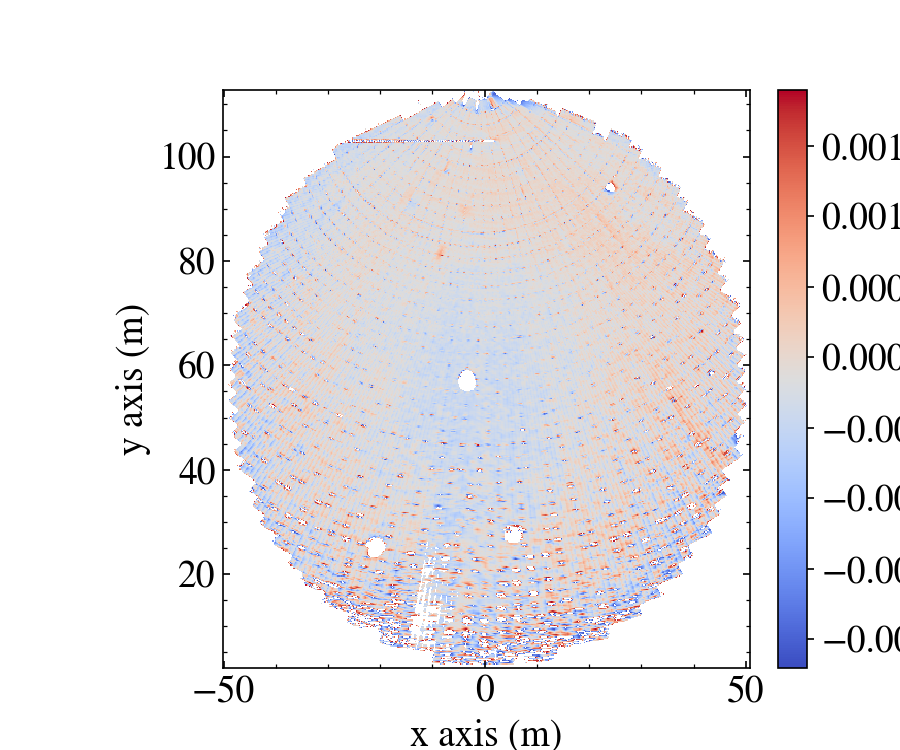

In [471]:
diff = sigma_clip(sDiff - rDiff, 5)
xDiff = xr
yDiff = yr

vmin = np.nanmin(diff)
vmax = np.nanmax(diff)
surfacePlot(xr, yr, diff.T, vMin=vmin, vMax=vmax, midPoint=(vmax+vmin)/2.)

In [472]:
diff.std()*1e6/400.

1.0145215368709777

In [473]:
betaDict = {5:1.1, 6:1.1, 7:1.15, 8:1.1, 9:1.1, 10:1.1, 11:1.1, 12:1.1, 13:1.3, 14:1.1, 
            15:1.3, 16:1.1, 17:1.1, 18:1.1, 19:1.1, 20:1.1, 21:1.1, 22:1.1, 23:1.1, 24:1.1, 25:1.1,
            26:1.1, 27:1.1, 28:1.1, 29:1.1, 30:1.1, 31:1.1, 32:1.1, 33:1.1, 34:1.1, 35:1.1, 36:1.1,
            37:1.1,
           }

stds = np.arange(0, 20, 2)
exp_fac = np.exp(-np.power((stds[4] - stds)/(5*diff.std()*1e6/60.), 2.))
scale_bias = lambda beta: np.power(beta, -1.+1.15*np.log2(stds/1.))*exp_fac

In [474]:
%%time

fl = np.zeros(nZern+1, dtype=np.float)

fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')

flArr = np.zeros((len(stds), nZern+1), dtype=np.float)

for j,std in enumerate(stds):
    if std != 0:
        kernel = Gaussian2DKernel(x_stddev=std)
        diffSmo = convolve(diff, kernel, preserve_nan=True)
    else:
        diffSmo = np.ma.copy(diff)
    diff_ = np.ma.copy(diffSmo)
    diff_[~radialMask(xDiff, yDiff, 49.5)] = np.nan
    diff_ = np.ma.masked_invalid(diff_)

    flArr[j] = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff_[::-1,::-1], nZern, weighted=False)

for j in range(4,nZern+1):
    if j == 4:
        fl[j] = fl_fs[j]
    else:
        if fl_fs[j] < flArr[0,j] and j == 13:
            fl[j] = fl_fs[j]
        else:
            sb = scale_bias(betaDict[j])
            best_idx = np.argmax(abs(flArr[1:,j])*1e6*sb[1:])
            fl[j] = flArr[best_idx+1,j]

/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:108: RuntimeWarning: invalid value encountered in less_equal
  return np.sqrt( (x - midPoint(x))**2. + (y - midPoint(y))**2. ) <= r


CPU times: user 1min 7s, sys: 6.7 s, total: 1min 13s
Wall time: 56.5 s


/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


In [475]:
sb = scale_bias(betaDict[iz])
sb = scale_bias(diff.std()*1e6/400.)
print(sb)

[0.         0.97110902 1.00476283 1.02525673 1.03595315 1.03786083
 1.03151613 1.01737775 0.99594696 0.96780652]


/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


In [476]:
abs(flArr[:,iz])*1e6*sb, flArr[:,iz]*1e6, fl_fs[iz]*1e6

(array([  0.        , 185.28009912, 193.44105519, 196.89037741,
        197.04877799, 194.05921246, 187.9450126 , 178.97808421,
        167.68907214, 154.73818392]),
 array([-184.97695951, -190.79227575, -192.52409528, -192.04007281,
        -190.21012551, -186.97999449, -182.20268922, -175.92097272,
        -168.37148794, -159.88545226]),
 -123.60206417091025)

In [477]:
expected = np.zeros(37)
expected[iz] = izv
print(iz, izv, fl[iz]*1e6, izv - fl[iz]*1e6)
best_idx = np.argmax(abs(flArr[1:,iz])*1e6*sb[1:])
print(iz, izv, flArr[best_idx+1,iz]*1e6, izv - flArr[best_idx+1,iz]*1e6)
#best_idx = np.argmax(abs(flArr[:,iz])*1e6*scale_bias2)
#print(flArr[best_idx,iz]*1e6, izv - flArr[best_idx,iz]*1e6)

13 -225 -175.9209727165846 -49.0790272834154
13 -225 -190.21012550623453 -34.78987449376547


In [412]:
-7249.683466070225

-7249.683466070225

In [413]:
-7249.683466070225--6420.966734613921

-828.7167314563039